# Import modules

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import random_split, DataLoader, Subset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.tensorboard import SummaryWriter
log_dir = "runs/CIFAR10"
os.makedirs(log_dir, exist_ok=True)
import datetime
import random

writer = SummaryWriter(log_dir)
print(f"TensorBoard logs will be saved to: {os.path.abspath(log_dir)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 64
epochs = 50
patience = 5
import sys

TensorBoard logs will be saved to: /content/runs/CIFAR10
Using device: cuda


# Task 1
**Load dataset**

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_val_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

#ten_percent = int(0.1*len(train_val_dataset))
#indices = random.sample(range(len(train_val_dataset)), ten_percent)
#train_val_dataset = Subset(train_val_dataset, indices)

train_size = int(0.8* len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

examples = iter(train_loader)
images, labels = next(examples)
img_grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=True)
writer.add_image('CIFAR10_samples', img_grid)
writer.close()

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Train samples: 40000
Validation samples: 10000
Test samples: 10000


**CNN**

In [3]:
class Net(nn.Module):
    def __init__(self, AF=nn.LeakyReLU(0.01)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.AF = AF

    def forward(self, x):
        x = self.pool(self.AF(self.conv1(x)))
        x = self.pool(self.AF(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = self.AF(self.fc1(x))
        x = self.AF(self.fc2(x))
        x = self.fc3(x)
        return x



**Train Network**

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, model_name, epochs=10, patience=5):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(f'runs/CIFAR10/{model_name}_{timestamp}')
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    patience_counter = 0
    best_val_loss = float('inf')

    for epoch in range(epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_val = 0
        total_val = 0

        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        writer.add_scalars('Loss', {
            'train': avg_train_loss,
            'val': avg_val_loss
        }, epoch)

        writer.add_scalars('Accuracy', {
            'train': train_accuracy,
            'val': val_accuracy
        }, epoch)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_name+'.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Train Acc = {train_accuracy:.2f}%, Val Acc = {val_accuracy:.2f}%")

        if epoch % 5 == 0:
            for name, param in model.named_parameters():
                writer.add_histogram(name, param, epoch)

    model.load_state_dict(torch.load(model_name+'.pth'))
    writer.close()

    # Plot Training & Validation Loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Over Epochs")
    plt.tight_layout()
    plt.show()

    return model, train_losses, val_losses, train_accuracies, val_accuracies

**Test Network**

In [5]:
def test_model(model, test_loader, criterion, device, model_name="model", tag_suffix=""):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(f'runs/CIFAR10/{model_name}_test_{timestamp}')

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total if total > 0 else 0

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Log to TensorBoard
    writer.add_scalar(f'Test/Loss{tag_suffix}', avg_loss)
    writer.add_scalar(f'Test/Accuracy{tag_suffix}', accuracy)
    writer.close()

    return avg_loss, accuracy

**Train with LeakyReLU and SGD**

Epoch 1: Train Loss = 2.2998, Val Loss = 2.2952, Train Acc = 10.33%, Val Acc = 10.64%
Epoch 2: Train Loss = 2.2896, Val Loss = 2.2849, Train Acc = 13.91%, Val Acc = 17.26%
Epoch 3: Train Loss = 2.2783, Val Loss = 2.2717, Train Acc = 18.89%, Val Acc = 19.86%
Epoch 4: Train Loss = 2.2629, Val Loss = 2.2535, Train Acc = 20.57%, Val Acc = 20.67%
Epoch 5: Train Loss = 2.2419, Val Loss = 2.2295, Train Acc = 20.98%, Val Acc = 20.89%
Epoch 6: Train Loss = 2.2157, Val Loss = 2.2013, Train Acc = 21.22%, Val Acc = 21.34%
Epoch 7: Train Loss = 2.1875, Val Loss = 2.1735, Train Acc = 21.77%, Val Acc = 21.88%
Epoch 8: Train Loss = 2.1605, Val Loss = 2.1477, Train Acc = 22.25%, Val Acc = 22.44%
Epoch 9: Train Loss = 2.1352, Val Loss = 2.1242, Train Acc = 23.12%, Val Acc = 23.26%
Epoch 10: Train Loss = 2.1110, Val Loss = 2.1013, Train Acc = 23.98%, Val Acc = 23.81%
Epoch 11: Train Loss = 2.0873, Val Loss = 2.0789, Train Acc = 24.93%, Val Acc = 24.93%
Epoch 12: Train Loss = 2.0644, Val Loss = 2.0583, Tr

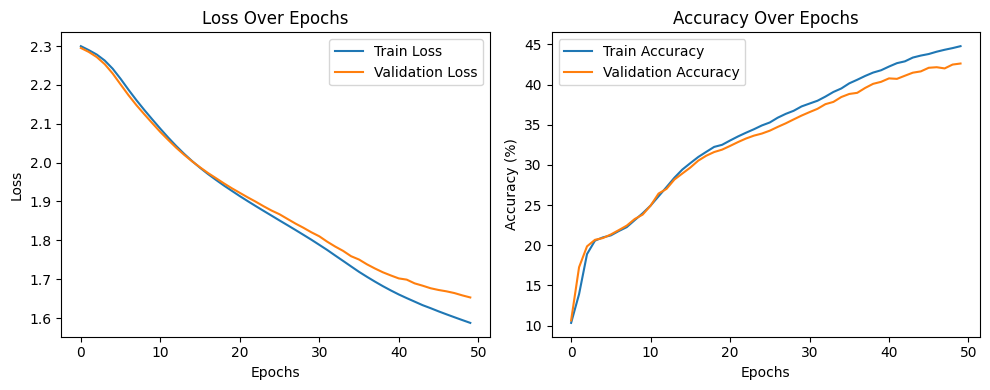

In [6]:
model_name_SGD = "model_SGD"
model_SGD = Net().to(device)
criterion_SGD = nn.CrossEntropyLoss()
optimizer_SGD = optim.SGD(model_SGD.parameters(), lr=0.0001)

model_SGD, train_losses_SGD, val_losses_SGD, train_accuracies_SGD, val_accuracies_SGD = train_model(model_SGD, train_loader, val_loader, criterion_SGD, optimizer_SGD,
                                                                                                    device, model_name_SGD, epochs, patience)

**Test with LeakyReLU and SGD**

In [7]:
test_loss_SGD, test_accuracy_SGD = test_model(model_SGD, test_loader, criterion_SGD, device)

Test Loss: 1.6364, Accuracy: 42.86%


**Train with LeakyReLU and Adam**

Epoch 1: Train Loss = 1.6913, Val Loss = 1.5000, Train Acc = 40.07%, Val Acc = 46.79%
Epoch 2: Train Loss = 1.3577, Val Loss = 1.3194, Train Acc = 52.02%, Val Acc = 52.96%
Epoch 3: Train Loss = 1.2038, Val Loss = 1.2390, Train Acc = 57.33%, Val Acc = 56.45%
Epoch 4: Train Loss = 1.0867, Val Loss = 1.2046, Train Acc = 62.00%, Val Acc = 57.69%
Epoch 5: Train Loss = 0.9849, Val Loss = 1.2072, Train Acc = 65.33%, Val Acc = 57.72%
Epoch 6: Train Loss = 0.8896, Val Loss = 1.1892, Train Acc = 69.27%, Val Acc = 59.15%
Epoch 7: Train Loss = 0.7934, Val Loss = 1.2160, Train Acc = 72.64%, Val Acc = 58.82%
Epoch 8: Train Loss = 0.6945, Val Loss = 1.2450, Train Acc = 76.17%, Val Acc = 59.22%
Epoch 9: Train Loss = 0.5976, Val Loss = 1.2905, Train Acc = 79.84%, Val Acc = 59.20%
Epoch 10: Train Loss = 0.5025, Val Loss = 1.3737, Train Acc = 83.35%, Val Acc = 59.02%
Early stopping


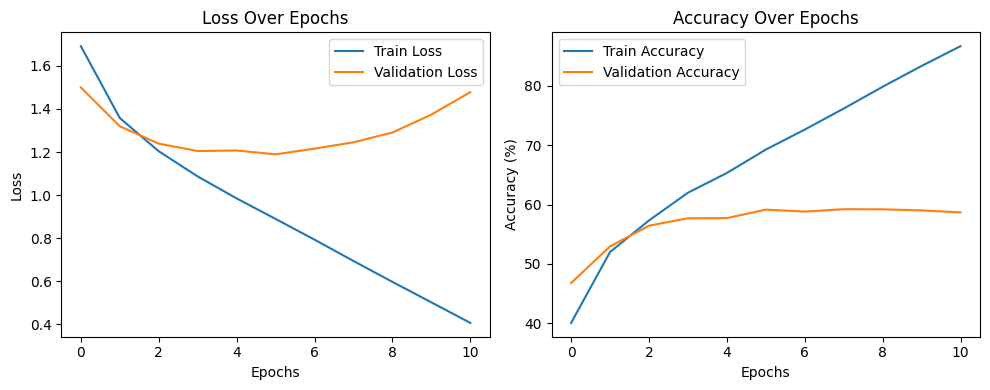

In [8]:
model_name_Adam = "model_Adam"
model_Adam = Net().to(device)
criterion_Adam = nn.CrossEntropyLoss()
optimizer_Adam = optim.Adam(model_Adam.parameters(), lr=0.0001)

model_Adam, train_losses_Adam, val_losses_Adam, train_accuracies_Adam, val_accuracies_Adam = train_model(model_Adam, train_loader, val_loader, criterion_Adam, optimizer_Adam, device,
                                                                                                         model_name_Adam, epochs, patience)

**Test with LeakyReLU and Adam**

In [9]:
test_loss_Adamtanh, test_accuracy_Adamtanh = test_model(model_Adam, test_loader, criterion_Adam, device)

Test Loss: 1.1818, Accuracy: 59.13%


**Train with Tanh and Adam**

Epoch 1: Train Loss = 2.3083, Val Loss = 2.3081, Train Acc = 9.30%, Val Acc = 9.30%
Epoch 2: Train Loss = 2.3083, Val Loss = 2.3081, Train Acc = 9.30%, Val Acc = 9.30%
Epoch 3: Train Loss = 2.3083, Val Loss = 2.3081, Train Acc = 9.30%, Val Acc = 9.30%
Epoch 4: Train Loss = 2.3083, Val Loss = 2.3081, Train Acc = 9.30%, Val Acc = 9.30%
Epoch 5: Train Loss = 2.3083, Val Loss = 2.3081, Train Acc = 9.30%, Val Acc = 9.30%
Early stopping


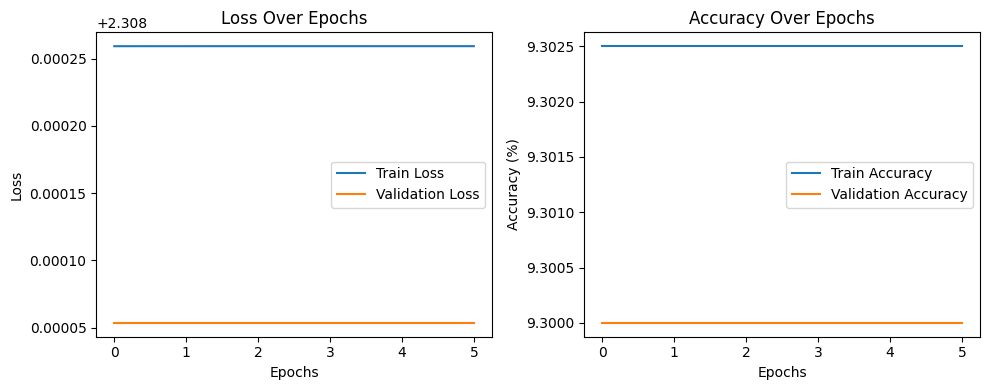

In [11]:
model_name_Adamtanh = "model_Adamtanh"
model_Adamtanh = Net(AF=nn.Tanh()).to(device)

criterion_Adamtanh = nn.CrossEntropyLoss()
optimizer_Adamtanh = optim.Adam(model_Adam.parameters(), lr=0.0001)

model_Adamtanh, train_losses_Adamtanh, val_losses_Adamtanh, train_accuracies_Adamtanh, val_accuracies_Adamtanh = train_model(model_Adamtanh, train_loader, val_loader, criterion_Adamtanh,
                                                                                                                             optimizer_Adamtanh, device, model_name_Adamtanh, epochs, patience)

**Test with Tanh and Adam**

In [12]:
test_loss_Adamtanh, test_accuracy_Adamtanh = test_model(model_Adamtanh, test_loader, criterion_Adamtanh, device)

Test Loss: 2.3078, Accuracy: 9.07%


# Task 2

**Fine Tuning**

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss = 1.5682, Val Loss = 1.1805, Train Acc = 41.60%, Val Acc = 56.95%
Epoch 2: Train Loss = 1.0867, Val Loss = 1.0099, Train Acc = 61.01%, Val Acc = 64.35%
Epoch 3: Train Loss = 0.8504, Val Loss = 0.8792, Train Acc = 69.93%, Val Acc = 68.89%
Epoch 4: Train Loss = 0.7027, Val Loss = 0.7132, Train Acc = 75.30%, Val Acc = 74.92%
Epoch 5: Train Loss = 0.5944, Val Loss = 0.6510, Train Acc = 79.09%, Val Acc = 77.25%
Epoch 6: Train Loss = 0.5032, Val Loss = 0.6181, Train Acc = 82.29%, Val Acc = 79.02%
Epoch 7: Train Loss = 0.4258, Val Loss = 0.5875, Train Acc = 84.98%, Val Acc = 79.92%
Epoch 8: Train Loss = 0.3588, Val Loss = 0.5949, Train Acc = 87.39%, Val Acc = 80.71%
Epoch 9: Train Loss = 0.2968, Val Loss = 0.6170, Train Acc = 89.48%, Val Acc = 80.99%
Epoch 10: Train Loss = 0.2482, Val Loss = 0.6400, Train Acc = 91.05%, Val Acc = 80.56%
Epoch 11: Train Loss = 0.2063, Val Loss = 0.6075, Train Acc = 92.72%, Val Acc = 81.50%
Early stopping


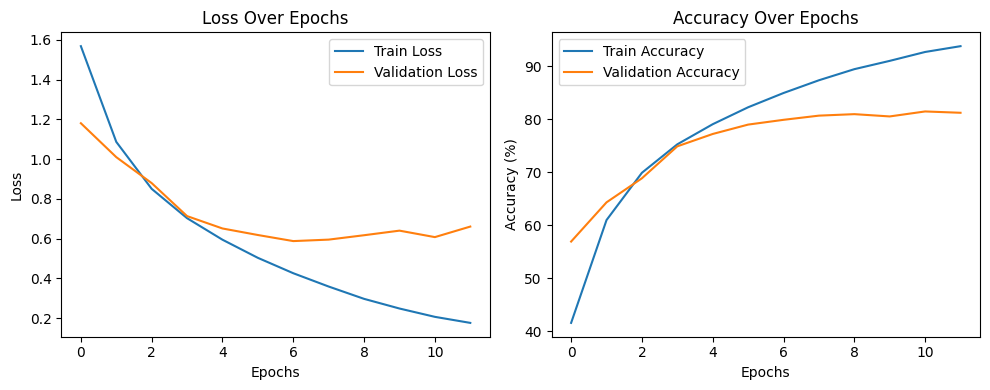

Test Loss: 0.5935, Accuracy: 80.22%


In [13]:
model_AlexNetft = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
model_name_AlexNetft = "model_alexnetft"
num_ftrs = model_AlexNetft.classifier[6].in_features
model_AlexNetft.classifier[6] = nn.Linear(num_ftrs, 10)

model_AlexNetft.to(device)

criterion_AlexNetft = nn.CrossEntropyLoss()
optimizer_AlexNetft = optim.Adam(model_AlexNetft.parameters(), lr=0.0001)

model_AlexNetft, train_losses_AlexNetft, val_losses_AlexNetft, train_accuracies_AlexNetft, val_accuracies_AlexNetft = train_model(model_AlexNetft, train_loader, val_loader,
                                                                                                                                  criterion_AlexNetft, optimizer_AlexNetft, device,
                                                                                                                                  model_name_AlexNetft, epochs, patience)
test_loss_AlexNetft, test_accuracy_AlexNetft = test_model(model_AlexNetft, test_loader, criterion_AlexNetft, device)

**Feature Extraction**

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 102MB/s]


Epoch 1: Train Loss = 0.6566, Val Loss = 0.4880, Train Acc = 76.89%, Val Acc = 82.91%
Epoch 2: Train Loss = 0.4296, Val Loss = 0.4058, Train Acc = 84.88%, Val Acc = 85.72%
Epoch 3: Train Loss = 0.3312, Val Loss = 0.4070, Train Acc = 88.25%, Val Acc = 86.12%
Epoch 4: Train Loss = 0.2583, Val Loss = 0.3768, Train Acc = 90.81%, Val Acc = 87.34%
Epoch 5: Train Loss = 0.2119, Val Loss = 0.3754, Train Acc = 92.41%, Val Acc = 87.51%
Epoch 6: Train Loss = 0.1678, Val Loss = 0.4076, Train Acc = 94.04%, Val Acc = 86.91%
Epoch 7: Train Loss = 0.1437, Val Loss = 0.3983, Train Acc = 94.81%, Val Acc = 87.43%
Epoch 8: Train Loss = 0.1129, Val Loss = 0.4172, Train Acc = 95.94%, Val Acc = 87.39%
Epoch 9: Train Loss = 0.0988, Val Loss = 0.4517, Train Acc = 96.55%, Val Acc = 87.01%
Early stopping


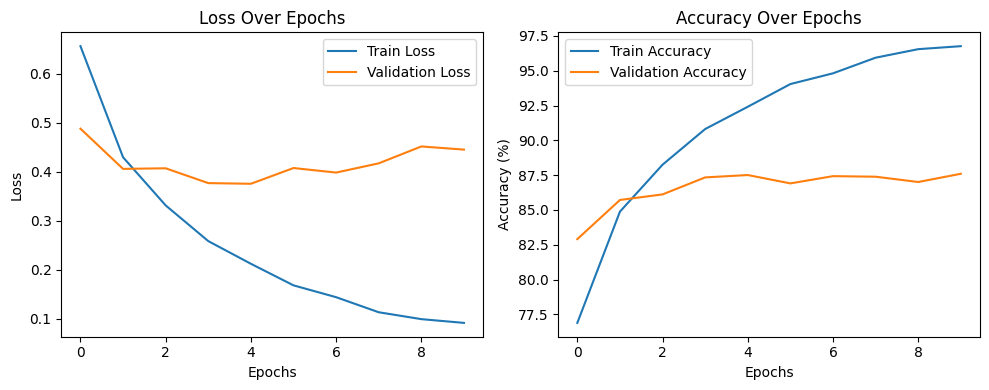

Test Loss: 0.3793, Accuracy: 87.14%


In [14]:
model_AlexNetfe = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_name_AlexNetfe = "alexnetfe"

for param in model_AlexNetfe.features.parameters():
    param.requires_grad = False

num_ftrs = model_AlexNetfe.classifier[6].in_features
model_AlexNetfe.classifier[6] = nn.Linear(num_ftrs, 10)

model_AlexNetfe.to(device)

criterion_AlexNetfe = nn.CrossEntropyLoss()
optimizer_AlexNetfe = optim.Adam(filter(lambda p: p.requires_grad, model_AlexNetfe.parameters()), lr=0.0001)

model_AlexNetfe, train_losses_AlexNetfe, val_losses_AlexNetfe, train_accuracies_AlexNetfe, val_accuracies_AlexNetfe = train_model(model_AlexNetfe, train_loader, val_loader,
                                                                                                                                  criterion_AlexNetfe, optimizer_AlexNetfe, device,
                                                                                                                                  model_name_AlexNetfe, epochs, patience)
test_loss_AlexNetfe, test_accuracy_AlexNetfe = test_model(model_AlexNetfe, test_loader, criterion_AlexNetfe, device)

## Explain (briefly!) what is the difference between the two runs and why there is a difference in performance

## Transfer Learning from MNIST

**Load dataset**

In [15]:
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

log_dir = "runs/MNIST"
os.makedirs(log_dir, exist_ok=True)

writer = SummaryWriter(log_dir)
print(f"TensorBoard logs will be saved to: {os.path.abspath(log_dir)}")

train_val_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

train_size = int(0.8* len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

examples = iter(train_loader)
images, labels = next(examples)
img_grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=True)
writer.add_image('MNIST_samples', img_grid)
writer.close()

TensorBoard logs will be saved to: /content/runs/MNIST


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.09MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.31MB/s]

Train samples: 48000
Validation samples: 12000
Test samples: 10000


**Initialize Model**

In [16]:
# LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.tanh = nn.Tanh()

        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(self.tanh(self.conv1(x)))
        x = self.pool(self.tanh(self.conv2(x)))
        x = self.tanh(self.conv3(x))

        x = x.view(x.size(0), -1)

        x = self.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


**Train Model**

Epoch 1: Train Loss = 0.9074, Val Loss = 0.4036, Train Acc = 79.03%, Val Acc = 89.32%
Epoch 2: Train Loss = 0.3297, Val Loss = 0.2705, Train Acc = 91.05%, Val Acc = 92.08%
Epoch 3: Train Loss = 0.2402, Val Loss = 0.2055, Train Acc = 93.07%, Val Acc = 94.02%
Epoch 4: Train Loss = 0.1857, Val Loss = 0.1614, Train Acc = 94.60%, Val Acc = 95.24%
Epoch 5: Train Loss = 0.1472, Val Loss = 0.1308, Train Acc = 95.74%, Val Acc = 96.18%
Epoch 6: Train Loss = 0.1206, Val Loss = 0.1103, Train Acc = 96.49%, Val Acc = 96.77%
Epoch 7: Train Loss = 0.1016, Val Loss = 0.0961, Train Acc = 97.05%, Val Acc = 97.13%
Epoch 8: Train Loss = 0.0878, Val Loss = 0.0856, Train Acc = 97.40%, Val Acc = 97.45%
Epoch 9: Train Loss = 0.0772, Val Loss = 0.0776, Train Acc = 97.71%, Val Acc = 97.63%
Epoch 10: Train Loss = 0.0686, Val Loss = 0.0723, Train Acc = 98.02%, Val Acc = 97.80%
Epoch 11: Train Loss = 0.0617, Val Loss = 0.0680, Train Acc = 98.20%, Val Acc = 97.96%
Epoch 12: Train Loss = 0.0564, Val Loss = 0.0646, Tr

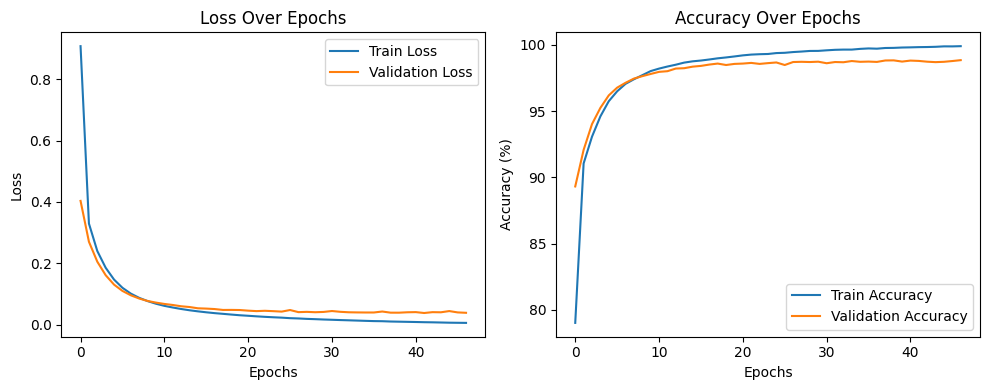

In [17]:
model_name_LeNet5 = "model_LeNet5"
model_LeNet5= LeNet5().to(device)
criterion_LeNet5 = nn.CrossEntropyLoss()
optimizer_LeNet5 = optim.Adam(model_LeNet5.parameters(), lr=0.0001)

model_LeNet5, train_losses_LeNet5, val_losses_LeNet5, train_accuracies_LeNet5, val_accuracies_LeNet5 = train_model(model_LeNet5, train_loader, val_loader, criterion_LeNet5,
                                                                                                                   optimizer_LeNet5, device, model_name_LeNet5, epochs, patience)

**Test Model**

In [18]:
test_loss_LeNet5, test_accuracy_LeNet5 = test_model(model_LeNet5, test_loader, criterion_LeNet5, device)

Test Loss: 0.0322, Accuracy: 98.92%


**Prepare SVHN dataset**

In [25]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

log_dir = "runs/SVHN"
os.makedirs(log_dir, exist_ok=True)

writer = SummaryWriter(log_dir)
print(f"TensorBoard logs will be saved to: {os.path.abspath(log_dir)}")

train_val_dataset = torchvision.datasets.SVHN(
    root='./data', split='train', download=True, transform=transform)
test_dataset = torchvision.datasets.SVHN(
    root='./data', split='test', download=True, transform=transform)

train_size = int(0.8* len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

examples = iter(train_loader)
images, labels = next(examples)
img_grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=True)
writer.add_image('MNIST_samples', img_grid)
writer.close()

TensorBoard logs will be saved to: /content/runs/SVHN
Train samples: 58605
Validation samples: 14652
Test samples: 26032


**Train on SVHN using pretrained MNIST model. (Fine Tuning)**


Epoch 1: Train Loss = 2.8690, Val Loss = 1.3429, Train Acc = 37.02%, Val Acc = 57.10%
Epoch 2: Train Loss = 1.1144, Val Loss = 0.9541, Train Acc = 64.81%, Val Acc = 70.58%
Epoch 3: Train Loss = 0.8715, Val Loss = 0.8120, Train Acc = 73.27%, Val Acc = 75.24%
Epoch 4: Train Loss = 0.7600, Val Loss = 0.7348, Train Acc = 76.86%, Val Acc = 77.56%
Epoch 5: Train Loss = 0.6931, Val Loss = 0.6898, Train Acc = 79.09%, Val Acc = 79.39%
Epoch 6: Train Loss = 0.6471, Val Loss = 0.6459, Train Acc = 80.58%, Val Acc = 80.70%
Epoch 7: Train Loss = 0.6110, Val Loss = 0.6103, Train Acc = 81.76%, Val Acc = 81.83%
Epoch 8: Train Loss = 0.5823, Val Loss = 0.5880, Train Acc = 82.66%, Val Acc = 82.70%
Epoch 9: Train Loss = 0.5587, Val Loss = 0.5726, Train Acc = 83.36%, Val Acc = 83.32%
Epoch 10: Train Loss = 0.5381, Val Loss = 0.5485, Train Acc = 84.08%, Val Acc = 84.00%


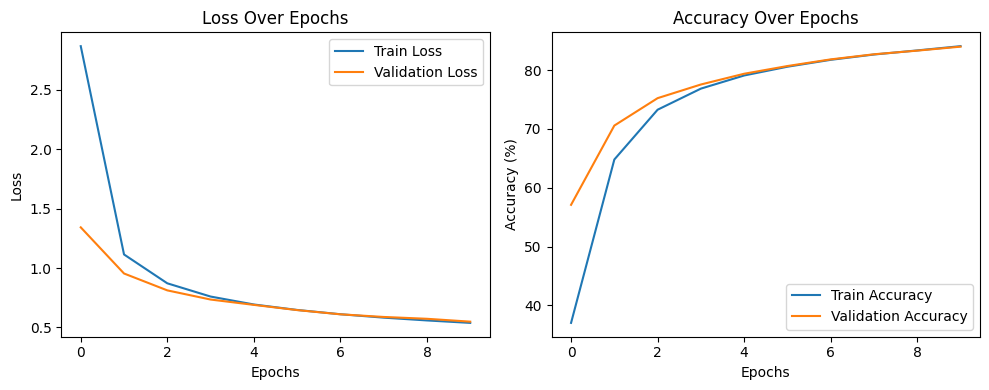

Test Loss: 0.6043, Accuracy: 82.33%


In [26]:
model_name_SVHN = "model_SVHN"
model_SVHN = LeNet5().to(device)
model_SVHN.load_state_dict(torch.load(model_name_LeNet5 + '.pth'))
criterion_SVHN = nn.CrossEntropyLoss()
optimizer_SVHN = optim.Adam(model_SVHN.parameters(), lr=0.0001)

model_SVHN, train_losses_SVHN, val_losses_SVHN, train_accuracies_SVHN, val_accuracies_SVHN = train_model(
    model_SVHN, train_loader, val_loader, criterion_SVHN, optimizer_SVHN, device, model_name=model_name_SVHN)

test_loss_SVHN, test_accuracy_SVHN = test_model(
    model_SVHN, test_loader, criterion_SVHN, device, model_name=model_name_SVHN)


**Train on SVHN using pretrained MNIST model. (Feature extraction)**

Epoch 1: Train Loss = 4.7764, Val Loss = 2.3271, Train Acc = 14.68%, Val Acc = 21.56%
Epoch 2: Train Loss = 2.1954, Val Loss = 2.1335, Train Acc = 24.33%, Val Acc = 26.11%
Epoch 3: Train Loss = 2.0652, Val Loss = 2.0235, Train Acc = 28.02%, Val Acc = 29.16%
Epoch 4: Train Loss = 1.9591, Val Loss = 1.9195, Train Acc = 31.70%, Val Acc = 33.62%
Epoch 5: Train Loss = 1.8592, Val Loss = 1.8220, Train Acc = 36.49%, Val Acc = 38.55%
Epoch 6: Train Loss = 1.7620, Val Loss = 1.7289, Train Acc = 41.32%, Val Acc = 42.65%
Epoch 7: Train Loss = 1.6734, Val Loss = 1.6465, Train Acc = 45.37%, Val Acc = 46.66%
Epoch 8: Train Loss = 1.5926, Val Loss = 1.5701, Train Acc = 48.90%, Val Acc = 49.03%
Epoch 9: Train Loss = 1.5249, Val Loss = 1.5102, Train Acc = 51.62%, Val Acc = 52.03%
Epoch 10: Train Loss = 1.4707, Val Loss = 1.4642, Train Acc = 53.66%, Val Acc = 53.50%


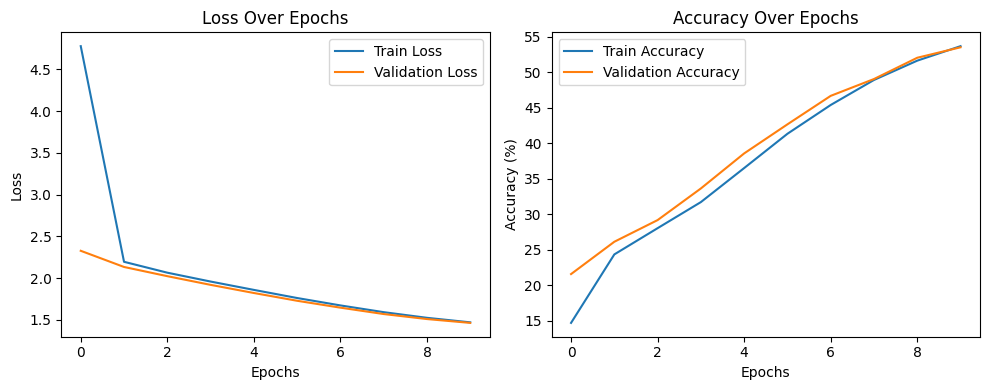

Test Loss: 1.4392, Accuracy: 55.16%


In [27]:

model_SVHN_FE = LeNet5().to(device)
model_SVHN_FE.load_state_dict(torch.load(model_name_LeNet5 + '.pth'))


for param in model_SVHN_FE.conv1.parameters():
    param.requires_grad = False
for param in model_SVHN_FE.conv2.parameters():
    param.requires_grad = False
for param in model_SVHN_FE.conv3.parameters():
    param.requires_grad = False


criterion_SVHN_FE = nn.CrossEntropyLoss()
optimizer_SVHN_FE = optim.Adam(filter(lambda p: p.requires_grad, model_SVHN_FE.parameters()), lr=0.0001)

model_SVHN_FE, train_losses_SVHN_FE, val_losses_SVHN_FE, train_accuracies_SVHN_FE, val_accuracies_SVHN_FE = train_model(
    model_SVHN_FE, train_loader, val_loader, criterion_SVHN_FE, optimizer_SVHN_FE, device, model_name="model_SVHN_FE"
)

test_loss_SVHN_FE, test_accuracy_SVHN_FE = test_model(
    model_SVHN_FE, test_loader, criterion_SVHN_FE, device, model_name="model_SVHN_FE"
)



**Download Workspace**

In [28]:
!zip -r /content/runs.zip /content/runs
from google.colab import files
files.download("/content/runs.zip")
files.download('model_SGD.pth')
files.download('model_Adam.pth')
files.download('model_Adamtanh.pth')
files.download('model_alexnetft.pth')
files.download('alexnetfe.pth')
files.download('model_LeNet5.pth')
files.download('model_SVHN.pth')
files.download('model_SVHN_FE.pth')

  adding: content/runs/ (stored 0%)
  adding: content/runs/MNIST/ (stored 0%)
  adding: content/runs/MNIST/events.out.tfevents.1743279753.62ace4296424.1247.32 (deflated 3%)
  adding: content/runs/SVHN/ (stored 0%)
  adding: content/runs/SVHN/events.out.tfevents.1743280695.62ace4296424.1247.45 (deflated 1%)
  adding: content/runs/SVHN/events.out.tfevents.1743280444.62ace4296424.1247.43 (deflated 1%)
  adding: content/runs/SVHN/events.out.tfevents.1743280437.62ace4296424.1247.42 (deflated 0%)
  adding: content/runs/SVHN/events.out.tfevents.1743280189.62ace4296424.1247.40 (deflated 0%)
  adding: content/runs/SVHN/events.out.tfevents.1743280138.62ace4296424.1247.39 (deflated 9%)
  adding: content/runs/CIFAR10/ (stored 0%)
  adding: content/runs/CIFAR10/model_test_20250329_202857/ (stored 0%)
  adding: content/runs/CIFAR10/model_test_20250329_202857/events.out.tfevents.1743280137.62ace4296424.1247.38 (deflated 15%)
  adding: content/runs/CIFAR10/model_test_20250329_195021/ (stored 0%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>